Searching through 30 summary files in /home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/aime/sc_32_control/summaries

--- Plotting Results ---
Largest difference (19,007 tokens) found in Question 24
  Min Correct Chain (32): 3,140 tokens
  Max Incorrect Chain (29): 22,147 tokens
  Correct Answer: 236


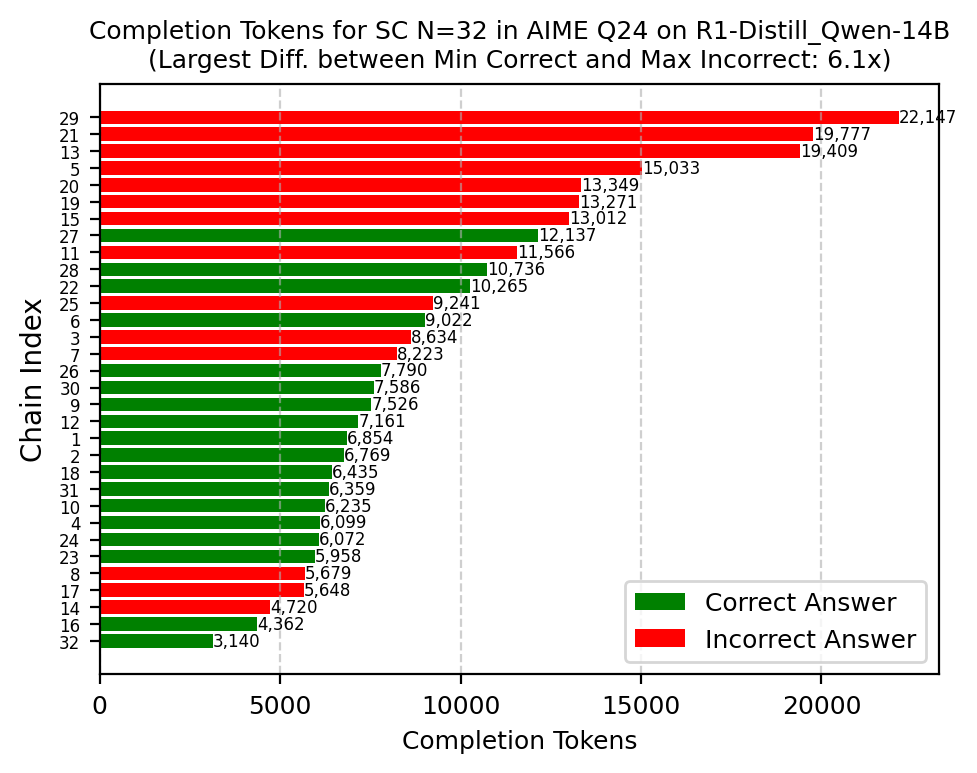

In [24]:
# Import necessary libraries
import os
import json
from pathlib import Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np # Added for sorting keys

# Set up plotting environment (as requested)
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.tab10.colors)

# Define base path (as requested)
user = os.environ.get("USER", "chong032") # Default to chong032 if USER env var not set
BASE_RESULTS_PATH = Path("/home/users/ntu/{user}/slimsc/prune/results".format(user=user))

# Define the specific directory containing the summaries
summary_dir = BASE_RESULTS_PATH / "R1-Distill-Qwen-14B/aime/sc_32_control/summaries/"

# --- Step 1: Find the question with the largest difference ---
#    between the min correct chain and the max incorrect chain

max_diff = -1 # Initialize with -1, as difference must be >= 0
best_question_info = None # Stores info about the question with the max difference

# Use glob to find all summary JSON files
# Sort by question number for consistent processing order
summary_files = sorted(summary_dir.glob('question_*.json'),
                       key=lambda x: int(x.stem.split('_')[1]) if x.stem.split('_')[0] == 'question' and len(x.stem.split('_')) > 1 and x.stem.split('_')[1].isdigit() else float('inf'))


print(f"Searching through {len(summary_files)} summary files in {summary_dir}")

if not summary_files:
    print(f"No summary files found in {summary_dir}. Please check the path.")
else:
    for file_path in summary_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)

            # Get correct answer
            correct_answer = str(data.get('correct_answer_letter', '')) # Ensure string, handle missing key

            # Extract question number from filename
            question_match = file_path.stem.split('_')
            question_number = None
            if len(question_match) > 1 and question_match[0] == 'question' and question_match[1].isdigit():
                 question_number = int(question_match[1])
            else:
                print(f"Skipping file with unexpected name format: {file_path.name}")
                continue # Skip if filename format is unexpected

            if 'chains_for_voting_details' in data and data['chains_for_voting_details']:
                chains_data = data['chains_for_voting_details']

                correct_chains = []
                incorrect_chains = []

                for chain_detail in chains_data:
                    # Ensure expected keys exist
                    if 'chain_index' in chain_detail and 'completion_tokens' in chain_detail and 'extracted_answer' in chain_detail:
                        extracted_answer = str(chain_detail['extracted_answer']) # Ensure string
                        is_correct = (extracted_answer == correct_answer)

                        # Store the chain details, including correctness status
                        chain_info = {
                            'chain_index': chain_detail['chain_index'],
                            'completion_tokens': chain_detail['completion_tokens'],
                            'is_correct': is_correct
                        }

                        if is_correct:
                            correct_chains.append(chain_info)
                        else:
                            incorrect_chains.append(chain_info)
                    else:
                         print(f"Warning: Skipping chain in {file_path.name} due to missing keys.")


                # Check if we have at least one correct and one incorrect chain
                if correct_chains and incorrect_chains:
                    # Find the chain with minimum completion tokens among correct ones
                    min_correct_chain = min(correct_chains, key=lambda x: x['completion_tokens'])

                    # Find the chain with maximum completion tokens among incorrect ones
                    max_incorrect_chain = max(incorrect_chains, key=lambda x: x['completion_tokens'])

                    # Calculate the difference
                    current_diff = max_incorrect_chain['completion_tokens'] - min_correct_chain['completion_tokens']

                    # Check if this is the largest difference found so far
                    if current_diff > max_diff:
                        max_diff = current_diff
                        best_question_info = {
                            "question_number": question_number,
                            "correct_answer": correct_answer, # Store correct answer for plotting colors
                            "min_correct_chain": min_correct_chain,
                            "max_incorrect_chain": max_incorrect_chain,
                            "difference": max_diff,
                            "all_chains_data": chains_data # Store ALL chain data for this question
                        }
                # else:
                    # print(f"Question {question_number} skipped (no correct or no incorrect chains).")

        except json.JSONDecodeError:
            print(f"Error decoding JSON from file: {file_path}")
        except FileNotFoundError:
             # This shouldn't happen with glob, but good practice
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"An unexpected error occurred while processing {file_path}: {e}")


# --- Step 2: Plot the results for the question with the largest difference ---

if best_question_info and best_question_info['all_chains_data']:
    print("\n--- Plotting Results ---")
    print(f"Largest difference ({best_question_info['difference']:,} tokens) found in Question {best_question_info['question_number']}")
    print(f"  Min Correct Chain ({best_question_info['min_correct_chain']['chain_index']}): {best_question_info['min_correct_chain']['completion_tokens']:,} tokens")
    print(f"  Max Incorrect Chain ({best_question_info['max_incorrect_chain']['chain_index']}): {best_question_info['max_incorrect_chain']['completion_tokens']:,} tokens")
    print(f"  Correct Answer: {best_question_info['correct_answer']}")

    # Prepare all chains data for plotting
    plot_df = pd.DataFrame(best_question_info['all_chains_data'])

    # Add 'is_correct' column to the DataFrame
    plot_df['is_correct'] = plot_df['extracted_answer'].astype(str) == best_question_info['correct_answer']

    # Sort by completion tokens
    plot_df = plot_df.sort_values(by='completion_tokens', ascending=True)

    # Determine colors based on correctness
    colors = plot_df['is_correct'].apply(lambda x: 'green' if x else 'red').tolist()

    # Create the horizontal bar plot
    plt.figure(figsize=(5, 4)) # Adjust figure size for more chains if needed
    bars = plt.barh(plot_df['chain_index'].astype(str), plot_df['completion_tokens'], color=colors)

    # Add labels and title
    plt.xlabel("Completion Tokens", fontsize=9)
    plt.xticks(fontsize=9)
    plt.ylabel("Chain Index")
    multiplier = best_question_info['difference']/best_question_info['min_correct_chain']['completion_tokens']
    plt.title(f"Completion Tokens for SC N=32 in AIME Q{best_question_info['question_number']} on R1-Distill_Qwen-14B\n(Largest Diff. between Min Correct and Max Incorrect: {multiplier:.1f}x)", fontsize=9)
    plt.grid(axis='x', linestyle='--', alpha=0.6) # Add horizontal grid lines

    # Add text labels on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, # Position text slightly right of the bar
                 f'{width:,}', # Text is the token count, formatted with comma
                 va='center', ha='left', fontsize=6) # Adjusted font size

    # Ensure y-axis labels are clearly the chain indices
    plt.yticks(plot_df['chain_index'].astype(str), fontsize=6)

    # Create a legend for colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', label='Correct Answer'),
                       Patch(facecolor='red', label='Incorrect Answer')]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=9)


    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

else:
    print("\nNo suitable question found with both correct and incorrect chains, or no data processed.")
    print("Please check the directory path, the content of the JSON files, and ensure questions have both correct and incorrect chains.")